In [1]:
import json
import numpy as np
import scipy
import os.path as op
import matplotlib.pyplot as plt
from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity
from core_functions.simulated_data import simdata_settings, simulate
from core_functions.core import get_theoretical_psd_COM

with open(f"{op.expanduser('~')}/.config/sso_config.json", "r") as f:
    config = json.load(f)
basepath = config['basepath']
loadpath = op.join(basepath, 'simdata', 'y_sim.mat')


In [2]:
# Set up model
fs, k, n, M, osc_freqs, rhos, var_state_nois, var_obs_noi, A, Q, R, B, Z, X0, S0 = simdata_settings()

x_dim = k*2

In [3]:
# TODO print/plot the model setup

In [4]:
# Simulate

T = 30000
blnSimS = False

ta = np.arange(T)/fs

if blnSimS:
    s=None
else:     
    s = np.zeros(T,dtype=int)
    s[ta>80]=1
    s[ta>200]=2

y, s, x = simulate(A, B, Q, R, Z, X0, S0, T, s=s)

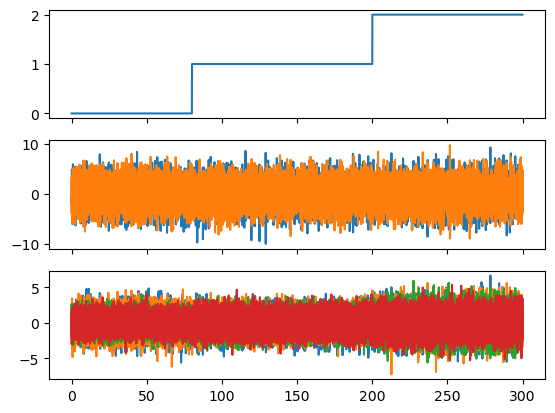

In [5]:
[fig,axs] = plt.subplots(3,1,sharex=True)
axs[0].plot(ta, s)
axs[1].plot(ta, x[:,0],ta,x[:,2])
axs[2].plot(ta, y)

(0.0, 40.0)

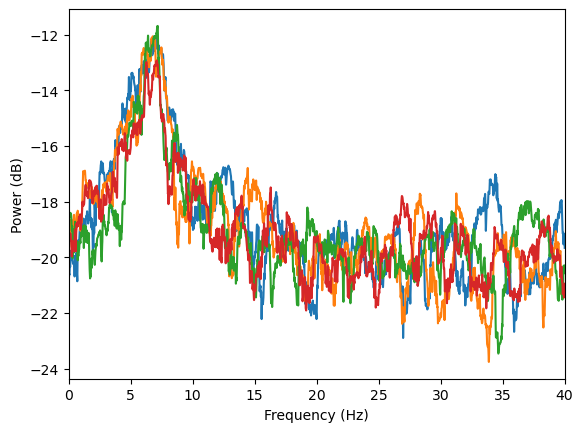

In [6]:
TW=3000
ntapers = 20

m = Multitaper(y,
                sampling_frequency=fs,
                time_halfbandwidth_product=TW,
                n_tapers=20,
                start_time=ta[0])
c = Connectivity(fourier_coefficients=m.fft(),
                frequencies=m.frequencies,
                time=m.time)

plt.figure()
plt.plot(c.frequencies, 10*np.log10(c.power().squeeze()))
plt.ylabel('Power (dB)')
plt.xlabel('Frequency (Hz)')
plt.xlim(0,40)


Text(0.5, 1.0, 'Loaded data')

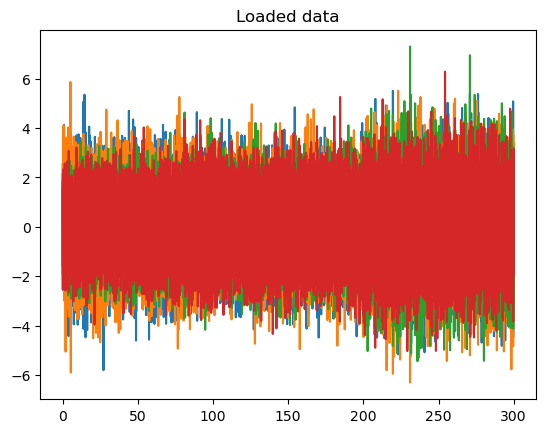

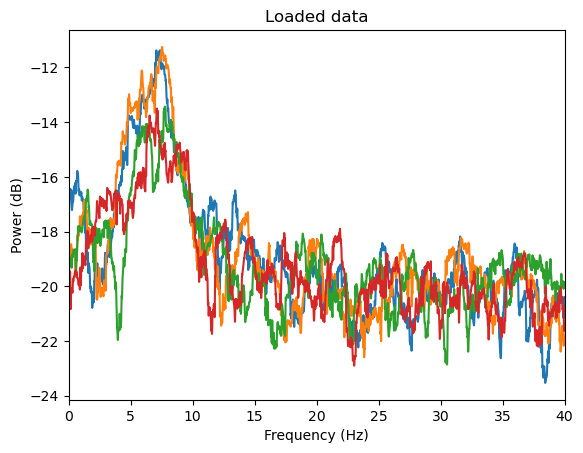

In [7]:
# Compare to existing data

y_load = scipy.io.loadmat(loadpath)['y'].T


plt.figure()
plt.plot(ta, y_load)
plt.title('Loaded data')

m_load = Multitaper(y_load,
                sampling_frequency=fs,
                time_halfbandwidth_product=TW,
                n_tapers=20,
                start_time=ta[0])
c_load = Connectivity(fourier_coefficients=m_load.fft(),
                frequencies=m_load.frequencies,
                time=m_load.time)

plt.figure()
plt.plot(c_load.frequencies, 10*np.log10(c_load.power().squeeze()))
plt.ylabel('Power (dB)')
plt.xlabel('Frequency (Hz)')
plt.xlim(0,40)

plt.title('Loaded data')

In [8]:
# Theoretical PSD

Stheo, Stheo_per_state = get_theoretical_psd_COM(c.frequencies,
                                                fs,
                                                osc_freqs,
                                                rhos,
                                                var_state_nois,
                                                var_obs_noi,
                                                B,
                                                s)

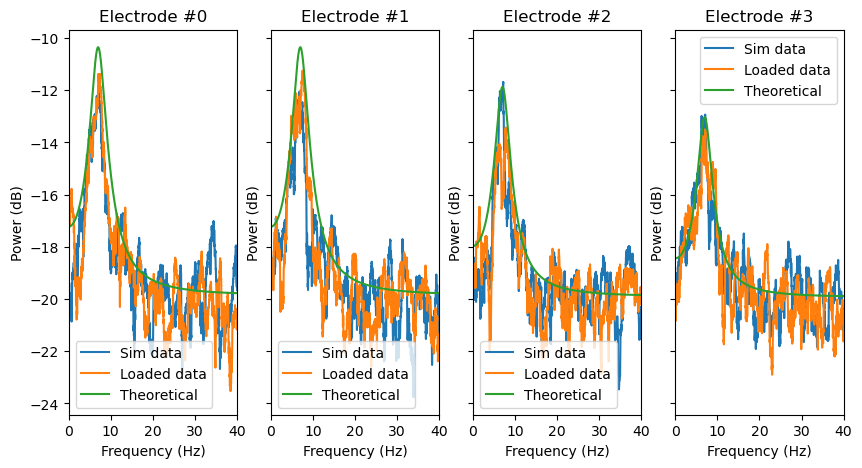

In [9]:
[fig, axs] = plt.subplots(1,n,sharex=True,sharey=True,figsize=[10,5])
for i in range(n):
    axs[i].plot(c.frequencies, 10*np.log10(c.power().squeeze()[:,i]),label='Sim data')
    axs[i].plot(c_load.frequencies, 10*np.log10(c_load.power().squeeze()[:,i]),label='Loaded data')
    axs[i].plot(c.frequencies,10*np.log10(Stheo[:,i]),label='Theoretical')
    axs[i].set_title(f'Electrode #{i}')
    axs[i].set_ylabel('Power (dB)')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].legend()
    axs[i].set_xlim(0,40)